# Aimsun Microsimulation SQLite Output Database Analyzer

### Goal of the notebook

This purpose of this Jupyter notebook is to process the database produced by the Aimsun microsimulations.
***
**Outputs:** 

Comparsion biplots:
- compare_link_flow.png
    - The unit of flow: veh/15min
- compare_speed.png
    - The unit of speed: mph
- compare_travel_time.png
    - The unit of travel time: seconds
- compare_path_flow.png (To do)


**Inputs:** 

Aimsun microsimulation outputs:
- aimsun-outputs.sqlite
    - The database should at least contain the following tables: SIM_INFO, MISECT, MIVEHTRAJECTORY and MIVEHSECTTRAJECTORY.
    - The last two tables can be generated by choosing outputing vehicle trajectories and enable subpath statistics in Aimsun.
    - Units: flow (veh/h), speed (km/h), travel time (s)
    

Ground truth data:
- flow_processed_2019.csv
    - Units: flow (veh/15min)
- 2015_Speed_Processed_Percent.csv
    - Units: speed (mph)
- TravelTime.csv
    - travel time (s)
    

**Dependent scripts:** 
None

**IMPORTANT:** Run the iPython cell below in order to import the necessary packages.

## To do:
0. For the analyser to work we need:
    - Aimsun microsimulation output
    - Flow, speed, detectors data
1. Explain the issues with Aimsun:
    - Aimsun crashes if we want to output the trajectory data
    - Aimsun should use 15 minutes time step in the data output, otherwise, we cannot create bi-plots
    - It seems that one of the speed detectors is not matched to Aimsun network anymore (road id: 35465 for speed 2015, detector id: 201503)
    - Path flow not done
2. Explain everything (solved: )
4. Do the path flow (not done yet --> a little bit hard)

In [1]:
# Root path of Fremont Dropbox
import os
import sys
# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fremontdropbox import get_dropbox_location

path_dropbox = get_dropbox_location()
data_folder = os.path.join(path_dropbox, 'Private Structured data collection')
sql_folder = os.path.join(data_folder, 'Aimsun','Outputs')

In [2]:
import numpy as np
import scipy
import matplotlib
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

### SQLite Helper Functions

These functions are wrapper functions for the underlying SQLite commands we use to query data from the SQLite database. The notebook assumes that the Aimsun database file has been placed into the current directory of the notebook.

In [3]:
def create_connection(db_file):
    """
    Open and make connection to the specified sqlite database.
    @param db_file:         file path of the sqlite database
    @return:                The database connection handler.
    """
    conn = sqlite3.connect(db_file)
    return conn

def create_df_from_sql_table(conn, table_name):
    """
    Create a dataframe for one sql table.
    @param conn:            The database connection handler.
    @param table_name:      The name of the table.
    @return:                A dataframe containing all the information of the sqlite table.
    """
    query = conn.execute("SELECT * From {}".format(table_name))
    cols = [column[0] for column in query.description]
    results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return results

def select_all_from_table(conn, table, should_print = True):
    """
    Select all rows from one sqlite table
    @param conn:            The database connection handler.
    @param table:           The name of the table.
    @should_print:          Whether the selected rows should be printed. Default True.
    @return:                All rows from one sqlite table.
    """
    cur = conn.cursor()
    if should_print:
        # Prevents us from accidentally clogging up the notebook with huge print statements
        cur.execute("SELECT * FROM {} LIMIT 10".format(table))
    else:
        cur.execute("SELECT * FROM {}".format(table))
    rows = cur.fetchall()
    if should_print:
        for row in rows:
            print(row)
    return rows

### Other helper functions

In [4]:
def get_sorted_x_y(x, y):
    """
    Given two sequences, sort the x,y pair ascendingly based on x. 
    This function is used to plot lines with incresing x.
    @param x:               The array of x coordinates.
    @param y:               The array of y coordinates.
    @return:                The sorted array of x and y with ascending x.
    """
    sort_x_y = sorted((i,j) for i,j in zip(x,y))
    X = []
    Y = []
    for i, j in sort_x_y:
        X.append(i)
        Y.append(j)
    return X, Y

To do: write a function to get biplots (solved: see below)

In [7]:
help(biplot)

Help on function biplot in module __main__:

biplot(x_data, y_data, x_label, y_label, title, filename)
    Draw the biplot given data, label and title. Fit a linear regression based on x_data and y_data. Save the figure to file.
    @param x_data:          The data for x coordinates.
    @param y_data:          The data for y coordinates.
    @param x_label:         The label for x axis.
    @param y_label:         The label for y axis.
    @param title:           The title of the figure.
    @param filename:        The name of the saved image (name only, path not included).
    @return:                R^2, slope and intercept of the fitted regression line.



In [6]:
# 
def biplot(x_data, y_data, x_label, y_label, title, filename):
    """
    Draw the biplot given data, label and title. Fit a linear regression based on x_data and y_data. Save the figure to file.
    @param x_data:          The data for x coordinates.
    @param y_data:          The data for y coordinates.
    @param x_label:         The label for x axis.
    @param y_label:         The label for y axis.
    @param title:           The title of the figure.
    @param filename:        The name of the saved image (name only, path not included).
    @return:                R^2, slope and intercept of the fitted regression line.
    """
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # fit a linear regression
    X = x_data
    Y_true = y_data

    X_con = sm.add_constant(X)
    res = sm.OLS(Y_true,X_con).fit()
    prstd, iv_l, iv_u = wls_prediction_std(res)

    X_sort, u = get_sorted_x_y(X, res.fittedvalues+prstd)
    _, l = get_sorted_x_y(X, res.fittedvalues-prstd)
    _, fit = get_sorted_x_y(X, res.fittedvalues)

    plt.plot(X_sort, fit, '-b', label='OLS fitted')
    plt.plot(X_sort, u, '-k', label = 'std upper')
    plt.plot(X_sort, l, '-k', label = 'std lower')
    plt.plot(X_sort, X_sort, '-r', label = 'ideal')
    plt.legend(loc='best');

    print("R^2: ", res.rsquared)
    print("slope", res.params[1])
    print("intercept", res.params[0])
    plt.savefig(filename)
    plt.show()
    return res.rsquared, res.params[1], res.params[0]

### SimulatorInfo Class (SIM_INFO Table)

This class parses information from the ```SIM_INFO``` table in the Aimsun database. This table stores meta information about the simulation in general, including the owner of the file and the version number currently in use.


### To do: add some references if any --> Aimsun tutorial. Take screenshot of the tutorial, make sure to have it available outside Aimsun. (solved: put in \Dropbox\Private Structured data collection\Aimsun\Outputs\Aimsun output database definition)

In [8]:
class SimulatorInfo:
    
    def __init__(self, values):
        self.data_id = values[0]
        self.data_id_name = values[1]
        self.effective_data_id = values[2]
        self.uses_external_id = True if values[4] else False
        self.scenario_date = values[5]
        self.start_time = values[6]
        self.duration = values[7]
        self.rand_seed = values[8]
        self.type = 'Simulated Data' if values[9] == 1 else 'Average'
        self.warm_up_time = values[10]
        self.sim_model = values[11]
        self.aimsun_version = values[12]
        self.num_iters = values[13]
        self.exec_date = values[14]
        self.experiment_id = values[15]
        self.experiment_name = values[16]
        self.scenario_id = values[17]
        self.scenario_name = values[18]
        self.simstatintervals = values[19]
        self.author = values[28]
        self.interval_second = self.duration//self.simstatintervals
        self.num_interval = (self.duration-self.warm_up_time)//self.interval_second

    def __str__(self):
        delimiter = ","
        return "Data ID: {}{}".format(self.data_id, delimiter) +\
            "Data ID Name: {}{}".format(self.data_id_name, delimiter) +\
            "Start Time: {}{}".format(self.start_time, delimiter) +\
            "Duration: {}{}".format(self.duration, delimiter) +\
            "Num intervals: {}{}".format(self.num_interval, delimiter) +\
            "Type: {}{}".format(self.type, delimiter) +\
            "Simulation Model: {}{}".format(self.sim_model, delimiter) +\
            "Execution Date: {}{}".format(self.exec_date, delimiter) +\
            "Scenarion Name: {}{}".format(self.scenario_name, delimiter) +\
            "Owner: {}".format(self.author)
    
    def __repr__(self):
        return str(self)

### Main AimsunAnalyzer Class

To be implemented. The skeleton code has been given below.

Tables ```MISECT```, ```MIVEHTRAJECTORY``` and ```MISECTVEHTRAJECTORY``` are converted into dataframes and stored before further analysis.

In [47]:
class AimsunAnalyzer:
    
    def __init__(self, simulation_file, simulation_filetype, ground_truth_file = None, ground_truth_filetype = None):
        """
        Initializes the Aimsun analyzer.
        
        @param simulation_file:          The file path of the source file of Aimsun macro/microsimulation outputs.
        @param simulation_filetype:      The type of the src_simulation file (can be .csv or .sqlite).
        @param ground_truth_file:        The file path of the source file of Aimsun macro/microsimulation outputs.
        @param ground_truth_filetype:    The type of the src_simulation file (can be .csv or .sqlite).
        """
        self.database = simulation_file
        self.conn = create_connection(self.database)
        print("=====Connection Established.=====")
        
        self.model_info = SimulatorInfo(select_all_from_table(self.conn, "SIM_INFO", should_print = False)[-1])
        self.start_hour = int(self.model_info.start_time)//3600
        self.start_min = int((self.model_info.start_time) - self.start_hour * 3600)//60
        self.interval_second = self.model_info.duration//self.model_info.simstatintervals
        print("Simulation starts at "+str(self.start_hour)+"h"+str(self.start_min)+"min")
        print("=====Model Information Loaded.=====")
        
        self.sections = create_df_from_sql_table(self.conn, "MISECT")
        self.vehTrajectory = create_df_from_sql_table(self.conn, "MIVEHTRAJECTORY")
        self.vehTrajectory["interval"] = self.vehTrajectory.apply(lambda row : self.convert_time_second_to_int(row["entranceTime"]) , axis=1)
        self.vehTrajectory["travelTime"] = self.vehTrajectory["exitTime"]-self.vehTrajectory["entranceTime"]
        self.vehSectTrajectory = create_df_from_sql_table(self.conn, "MIVEHSECTTRAJECTORY")
        self.vehSectTrajectory["interval"] = self.vehSectTrajectory.apply(lambda row : self.convert_time_second_to_int(row["exitTime"]) , axis=1)

        print("=====Simulation Data Loaded.=====")
        
        self.ground_truth_file = ground_truth_file
        self.ground_truth_filetype = ground_truth_filetype
        
    def convert_time_second_to_int(self, time_second):
        """
        Given a timestamp in seconds, returns the time interval as an int. 
        @param time_second:     The timestamp represented as seconds starting from 12:00AM, i.e. 14:45 is 53100 in seconds.
        @return:                The time interval as an int, i.e if 15 min is one interval and the simulation starts at 14:00, 
                                input 53100 -> output 3
        """
        time_second = int(time_second)
        time = (time_second-self.model_info.start_time)//self.interval_second
        return int(time)
        
    def convert_time_str_to_int(self, time_str):
        """
        Given a timestamp in string format, returns the time interval as an int. 
        @param time_str:        The timestamp represented as a string, i.e. "14:45".
        @return:                The time interval as an int, i.e if 15 min is one interval and the simulation starts at 14:00, 
                                input 14:45 -> output 3
        """
        dt = datetime.datetime.strptime(time_str, '%H:%M')
        time_second = dt.hour*3600 + dt.minute*60
        return self.convert_time_second_to_int(time_second)
    
    def get_link_flow(self, road_id, time_interval, time_type='string'):
        """
        Returns the link flow for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun in string format, i.e. "1242".
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", or an int.
        @param time_type:       The type of the input time_interval, can be "string" or "int". Default "string".

        @return:                The link flow on the road with road_id within the time interval.
        """
        if time_type=='int':
            time = time_interval
        else:
            time = self.convert_time_str_to_int(time_interval)
        
        # Here we sum up the flow in all lanes of one section.
        flow = self.sections[(self.sections["eid"]==road_id) & (self.sections["ent"]==time)]["flow"].sum()
        return flow

    def get_speed(self, road_id, time_interval, time_type='string'):
        """
        Returns the speed for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun in string format, i.e. "1242".
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", or an int.
        @param time_type:       The type of the input time_interval, can be "string" or "int". Default "string".

        @return:                The speed on the road with road_id within the time interval.
        """
        if time_type=='int':
            time = time_interval
        else:
            time = self.convert_time_str_to_int(time_interval)
        # for the current simulation, all lanes of one section share the same speed.
        speed = self.sections[(self.sections["eid"]==road_id) & (self.sections["ent"]==time)]["speed"].values[0]
        if speed==-1:
            return 0
        return speed
    
    # try to get the link travel time from different tables (MISECT, MIVEHTRAJECTORY or MISECTVEHTRAJECTORY) amd compare them
    def get_link_travel_time(self, road_id, time_interval, time_type='string'):
        # If the link travel time is not defined for the specific time step, set travel time as 5 hours
        """
        Returns the travel time for a certain section at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun in string format, i.e. "1242".
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All". Default "string".

        @return:                The average travel time on a certain section within the time interval
        """
        if time_type=='int':
            time = time_interval
        elif time_type=="string":
            time = self.convert_time_str_to_int(time_interval)
            
        selective = (self.vehSectTrajectory["sectionId"]==road_id)
        if time_type!="All":
            selective = selective & (self.vehSectTrajectory["interval"]==time)
        if np.sum(selective)==0:
            return 5*60*60 # 5 hours if the section is never used in the simulation --> we do not konw what to do here
        
        # Here we do the average over vehicles. Get a idea of standard deviation
        travel_time = self.vehSectTrajectory[selective]["travelTime"].mean()
        return travel_time
        # try to get the link travel time from different tables (MIVEHTRAJECTORY or MISECTVEHTRAJECTORY) amd compare them
    def get_OD_travel_time_aux(self, o_id, d_id, time_interval, time_type='string'):
        """
        Returns the mean travel time, demand, boolean selection to travel from an origin ID to a destination ID, within a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".

        @return:                The average OD travel time, the OD demand, boolean selection of entries within the time interval.
        """
        if time_type=='int':
            time = time_interval
        elif time_type=="string":
            time = self.convert_time_str_to_int(time_interval)
        selective = self.vehTrajectory["travelTime"]>0
        if o_id != 'All':
            selective = selective & (self.vehTrajectory["origin"]==o_id) 
        if d_id != 'All':
            selective = selective & (self.vehTrajectory["destination"]==d_id)
        if time_type!="All":
            selective = selective & (self.vehTrajectory["interval"]==time)
        if np.sum(selective)==0:
            return -1
        
        # Here we do the average over vehicles. Get a idea of standard deviation. Maybe use that to get some notion of regret.
        travel_time = self.vehTrajectory[selective]["travelTime"].mean()
        count = self.vehTrajectory[selective]["travelTime"].count()
        return travel_time, count, selective
    
    def get_OD_travel_time(self, o_id, d_id, time_interval, time_type='string'):
        """
        Returns the average travel time of paths between an origin and a destination, within a certain time interval.
        
        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".
                                
        @return:                The average travel time within the time interval from o_id to d_id.
        """
        tt, _, _ = self.get_OD_travel_time_aux(o_id, d_id, time_interval, time_type)
        return tt
    
    def get_OD_demand(self, o_id, d_id, time_interval, time_type='string'):
        """
        Returns the demand between an origin and a destination, within a certain time interval.
        
        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".
                                
        @return:                The OD demand within the time interval.
        """
        _, count, _ = self.get_OD_travel_time_aux(o_id, d_id, time_interval, time_type)
        return count
    
    def get_OD_distance(self, o_id, d_id, time_interval, time_type='string'):
        """
        Returns the average distance of paths between an origin and a destination, within a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".
                                
        @return:                The average distance, boolean selection of entries within the time interval from o_id to d_id.
        """
        if time_type=='int':
            time = time_interval
        elif time_type=="string":
            time = self.convert_time_str_to_int(time_interval)
        selective = self.vehTrajectory["travelledDistance"]>0
        if o_id != 'All':
            selective = selective & (self.vehTrajectory["origin"]==o_id) 
        if d_id != 'All':
            selective = selective & (self.vehTrajectory["destination"]==d_id)
        if time_type!="All":
            selective = selective & (self.vehTrajectory["interval"]==time)
        if np.sum(selective)==0:
            return -1
        
        # Here we do the average over vehicles. Get a idea of standard deviation. Maybe use that to get some notion of regret.
        distance = self.vehTrajectory[selective]["travelledDistance"].mean()
        return distance, selective

    # ax is a subfigure
    def plot_distribution(self, ax, data, title, xlabel, ylabel, bin_num=100):
        """
        Plots the histogram of data.
        
        @param ax:              A subfigure instance created by fig.add_subplot().
        @param data:            The data to create histogram.
        @param xlabel:          The label of x-axis.
        @param ylabel:          The label of y-axis.
        @param bin_num:         The number of bins in the histogram, default 100.
        
        @return:                None.
        """
        ax.hist(data, bins=bin_num)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel);
        
    def get_OD_distribution(self, o_id, d_id, dist_type, time_interval, time_type='string'):
        """
        Plots the OD distribution of travel time or distance between an origin and a destination, within a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid
        @param dist_type:       The type of distribution to extract, can be either "travel time" or "distance"
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".
                                
        @return:                None.
        """
        
        if dist_type == 'travel time':
            xlabel = 'Travel time (s)'
            _, _, selective = self.get_OD_travel_time_aux(o_id, d_id, time_interval, time_type)
            data = self.vehTrajectory[selective]["travelTime"]
        elif dist_type == 'distance':
            xlabel = 'Travelled distance (m)'
            _, selective = self.get_OD_distance(o_id, d_id, time_interval, time_type)
            data = self.vehTrajectory[selective]["travelledDistance"]
        else:
            print("Error: The distribution type is not valid.")
            return
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        title = "Distribution of OD {} from o_id {} to d_id {} at interval {}".format(dist_type, o_id, d_id, time_interval)
        ylabel = "Number of vehicles"
        self.plot_distribution(ax, data, title, xlabel, ylabel);
        
    # Parameter separate means separating commuter with resident
    def get_total_demand_distribution(self, dist_type, time_interval, time_type='string', separate=False):
        """
        Plots the total distribution of OD travel time or distance within the time interval for all pairs of OD.

        @param dist_type:       The type of distribution to extract, can be either "travel time" or "distance"
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", an integer 3, or "All".
        @param time_type:       The type of the input time_interval, can be "string", "int" or "All", 
                                if "string" or "int", the function computes the statistics over the specified interval, 
                                otherwise over the whole simulation. Default "string".
        @param separate:        If True, commuter and resident demand are computed and plotted separately.
        
        @return:                None.
        """
        if dist_type == 'travel time':
            col = "travelTime"
            xlabel = 'Travel time (s)'
            _, _, selective = self.get_OD_travel_time_aux('All', 'All', time_interval, time_type)
            
        elif dist_type == 'distance':
            col = 'travelledDistance'
            xlabel = 'Travelled distance (m)'
            _, selective = self.get_OD_distance('All', 'All', time_interval, time_type)
        else:
            print("Error: The distribution type is not valid.")
            return
        
        if separate:
            fig = plt.figure(figsize=(15, 5))
            ylabel = "Number of vehicles"
            
            selective_resident = selective & (self.vehTrajectory['sid']==63068)
            data_resident = self.vehTrajectory[selective_resident][col]
            selective_commuter = selective & (self.vehTrajectory['sid']==63069)
            data_commuter = self.vehTrajectory[selective_commuter][col]
            
            ax1 = fig.add_subplot(1,2,1)
            title = "Distribution of all OD {} for resident at interval {}".format(dist_type, time_interval)
            self.plot_distribution(ax1, data_resident, title, xlabel, ylabel);
            
            ax2 = fig.add_subplot(1,2,2)
            title = "Distribution of all OD {} for commuter at interval {}".format(dist_type, time_interval)
            self.plot_distribution(ax2, data_commuter, title, xlabel, ylabel);
            
        else:
            data = self.vehTrajectory[selective][col]
            fig = plt.figure(figsize=(8, 5))
            ax = fig.add_subplot(1,1,1)
            title = "Distribution of all OD {} at interval {}".format(dist_type, time_interval)
            ylabel = "Number of vehicles"
            self.plot_distribution(ax, data, title, xlabel, ylabel);
        
    def get_total_distribution(self, separate = False):
        """
        Plots the total distribution of OD travel time and distance, over all time intervals and for all pairs of OD.

        @param separate:        If True, commuter and resident demand are computed and plotted separately.
        
        @return:                None.
        """
        self.get_total_demand_distribution('distance', 'All', 'All', separate=separate)
        self.get_total_demand_distribution('travel time', 'All', 'All', separate=separate)
    def get_path_flow(self, o_id, d_id, distribution_type, time_interval):
        """
        Returns the path flow from an origin ID to a destination ID, within a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval, represented as a string, i.e. "14:45", or an int.

        @return:                The path flow within the time interval between start_time and end_time and
                                from o_id to d_id formatted as [(road_ids_1, flow_1), (road_ids_2, flow_2), ...]
        """
        # To do
        pass
    
    def compare_flow(self, flow_ground):
        """
        Plots the comparison graph bewteen non-zero simulation flow and corresponding ground-truth flow. 

        @param flow_ground:     The ground-truth flow data.

        @return:                None.             
        """
        flow_ground["Road_Id"] = flow_ground["Road_Id"].astype(int).astype(str)
        flow_ground["Detector_Id"] = flow_ground["Detector_Id"].astype(int).astype(str)
        
        # select valid time interval
        time_interval = flow_ground.loc[:,"14:0":"19:45"].columns

        # ground flow unit: # vehicles per 15min
        # simluation flow unit: # of vechicles per hour, have to be converted it to per 15 min
        for time in time_interval:
            flow_ground["sim_flow_"+str(time)]=flow_ground.apply(lambda row : (self.get_link_flow(row['Road_Id'], time))/4, axis=1)
        
        # plot flow biplot for all time intervals
        fig = plt.figure()
        ground_data_all = pd.Series()
        sim_data_all = pd.Series()

        for time in time_interval:
            to_show = flow_ground["sim_flow_"+str(time)]!=0 # only compare when the simulation flow is not 0.
            plt.scatter(flow_ground[to_show][time], flow_ground[to_show]["sim_flow_"+str(time)])
            sim_data_all = sim_data_all.append(flow_ground[to_show]["sim_flow_"+str(time)], ignore_index=True)
            ground_data_all = ground_data_all.append(flow_ground[to_show][time], ignore_index=True)

        biplot(ground_data_all.values, sim_data_all.values, 
               "flow ground data (veh/15 min)", "flow simulation data (veh/15 min)", 
               "Flow comparsion between sim and ground data\n using Aimsun Week 25 microsimulation", 
               "flow_comparsion.png");

    def compare_speed(self, speed_ground, speed_raw_folder):
        """
        Plots the comparison graph bewteen non-zero simulation speed and corresponding ground-truth speed. 

        @param speed_ground:     The ground-truth speed data.
        @param speed_raw_folder: The folder containing all raw files for speed survey, used to extract mean speed. 

        @return:                 None.                         
        """
        speed_ground["Road_Id"] = speed_ground["Road_Id"].astype(int).astype(str)
        speed_ground["Detector_Id"] = speed_ground["Detector_Id"].astype(int).astype(str)
        speed_ground["StartTime"] = speed_ground["StartTime"].str[:-3]
        speed_ground["EndTime"] = speed_ground["EndTime"].str[:-3]

        # if the measured time for ground data is not within the simulation time 2pm-8pm, label the interval as 0.
        speed_ground["SimTime"] = speed_ground["StartTime"]
        speed_ground.at[(speed_ground["SimTime"]<"14:00") | (speed_ground["SimTime"]>"20:00"), "SimTime"] = "14:00"

        for f in os.listdir(speed_raw_folder):
            if('xls' in f):
                file = pd.read_excel(os.path.join(speed_raw_folder, f), sheet_name = "Sheet1")
                mean_speed = file.iloc[28,7]
                speed_ground.at[speed_ground['Name']==f,'Mean_speed (mph)']=mean_speed
            
        # ground speed unit: mph
        # simulation speed is in km/h, need to be converted to mph
        speed_ground["sim_speed"]=speed_ground.apply(lambda row : (self.get_speed(row['Road_Id'], row['SimTime']))/1.6 , axis=1)
        
        # plot speed biplot for all time intervals
        fig = plt.figure()
        to_show = speed_ground["sim_speed"]!=0
        plt.scatter(speed_ground[to_show]["Mean_speed (mph)"], speed_ground[to_show]["sim_speed"])

        biplot(speed_ground[to_show]["Mean_speed (mph)"].values, speed_ground[to_show]["sim_speed"].values, 
               "speed ground data (mph)", "speed simulation data (mph)", 
               "Speed comparsion between sim and ground data\n using Aimsun Week 25 microsimulation", 
               "speed_comparsion.png");

    def compare_travel_time(self, travel_time_ground, ID_corr, od_ids='All', time_intervals='All'):
        """
        Plots the comparison graph bewteen simulation and ground-truth travel time between external centroids only. 

        @param travel_time_ground: The ground-truth travel time data. Currently only ext-ext travel time is available in the ground file.
        @param od_ids:             A list of tuples of CID of the centroids (not EID), i.e. [("ext13", "ext20"), ("ext20", "ext13"), ...], default 'All'.
        @time_intervals:           A list of time intervals as integers, i.e. [0,4,8,....], default 'All'.
        
        @return:                   None.
        """
        travel_time_ground['interval'] = travel_time_ground.apply(lambda row: self.convert_time_second_to_int(row['time']*3600), axis=1)
        travel_time_ground.at[(travel_time_ground["interval"]<0) | (travel_time_ground["interval"]>24), 'interval'] = -1
        
        def CID2EID(cid, df):
            """
            Given Centroid ID of a centroid, returns the external ID of this centroid.
            @param cid:            The centroid ID of a centroid, i.e. "int_0" or "ext_13".
            @param df:             The dataframe with correspondence between CID and EID.
            @return:               The external ID of the centroid, i.e. input "int_0" -> output 66801.
            """
            return df[df['Name']==cid]['ID'].values[0]

        def EID2CID(eid, df):
            """
            Given external ID of a centroid, returns the Centroid ID of this centroid.
            @param eid:             The external ID of a centroid, i.e. 66801.
            @param df:              The dataframe with correspondence between CID and EID.
            @return:                The centroid ID of the centroid, i.e. input 66801 -> output "int_0".
            """
            return df[df['ID']==eid]['Name'].values[0]

        def plot_travel_time(df, od_ids, time_intervals):
            """
            Draws the biplot of travel time for some od pairs within some time intervals.
            @param df:              The dataframe containing simulation and ground travel time.
            @param od_ids:          A list of tuples of CID of the centroids (not EID), i.e. [("ext13", "ext20"), ("ext20", "ext13"), ...], default 'All'.
            @time_intervals:        A list of time intervals as integers, i.e. [0,4,8,....], default 'All'.
        
            @return:                None.
            """
            selective = (df["travelTime"]>0) & (df["ground_travel_time"]>0)
            if (od_ids!='All'):
                s2 = pd.Series([False]*len(df))
                for oid, did in od_ids:
                    s2 = s2 | ( (df["CID_O"]==oid) & (df["CID_D"]==did) )
                selective  = selective & s2
            if (time_intervals!='All'):
                s2 = pd.Series([False]*len(df))
                for time in time_intervals:
                    s2 = s2 | ( df['corres_ground_interval']==time )
                selective  = selective & s2

            fig = plt.figure()
            to_show = selective
            plt.scatter(df[to_show]["ground_travel_time"], df[to_show]["travelTime"])
            
            biplot(df[to_show]["ground_travel_time"].values, df[to_show]["travelTime"].values, 
                   "travel time ground data (s)", "travel time simulation data (s)", 
                   "Travel time comparsion between sim and ground data\n using Aimsun Week 25 microsimulation", 
                   "travel_time_comparison.png");

        def compare_travel_time_ext_ext(od_ids, time_intervals):
            """
            Draws the biplot of travel time for some od pairs within some time intervals.
            @param od_ids:          A list of tuples of CID of the centroids (not EID), i.e. [("ext13", "ext20"), ("ext20", "ext13"), ...], default 'All'.
            @time_intervals:        A list of time intervals as integers, i.e. [0,4,8,....], default 'All'.
        
            @return:                None.
            """
            veh = self.vehTrajectory.copy()
            veh["corres_ground_interval"] = veh['interval']
            # for trips start at 14:00-15:59, treat it as starting at 14:00, otherwise comment the previous line and uncomment the following line
            # veh["corres_ground_interval"]=(veh['interval']//8)*8

            veh = veh[veh["travelTime"]>0].groupby(['origin', 'destination','corres_ground_interval'])[["travelTime"]].mean()
            veh = veh.reset_index()

            veh["CID_O"]= veh.apply(lambda row: EID2CID(row["origin"], ID_corr),axis=1)
            veh["CID_D"]= veh.apply(lambda row: EID2CID(row["destination"], ID_corr),axis=1)

            veh["ground_travel_time"] = -1

            # only ext-ext travel time will be compared since ground data only contains ext-ext
            selective = (veh["CID_O"].str[0:3]=="ext") & (veh["CID_D"].str[0:3]=="ext")
            if (time_intervals!='All'):
                s2 = pd.Series([False]*len(veh))
                for time in time_intervals:
                    s2 = s2 | (veh['corres_ground_interval']==time )
                selective  = selective & s2

            veh.at[selective, "ground_travel_time"]=veh[selective].apply(lambda row: \
                                                travel_time_ground[(travel_time_ground['interval']==row['corres_ground_interval'])& \
                                                ( travel_time_ground['ori_external_id']==int(row['CID_O'][4:]) ) & \
                                                ( travel_time_ground['des_external_id']==int(row['CID_D'][4:]) )]['travel_time'].values[0], axis=1) 

            plot_travel_time(veh, od_ids=od_ids, time_intervals=time_intervals)
            # plot_travel_time(analyzer.vehTrajectory, od_ids= [("ext_13", "ext_20"), ("ext_20", "ext_13")], time_intervals=[0,1,2,3,4,5,6,7,8,9])
        
        compare_travel_time_ext_ext(od_ids=od_ids, time_intervals=time_intervals)

    def compare_path_flow(self, od_ids='All', time_intervals='All'):
        """
        Returns a matplotlib plot with comparison information on the path flows for the given origin/destination
        centroid IDs at the specified time intervals.

        @param od_ids:                A list of tuples of (o_id, d_id)
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average path flows.
        """
        # Put this outside the class
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

## Following functions will be written later

## Main Code

This section contains the code that should be run in order to generate results in this notebook. Below is the necessary starter code that connects to the database and outputs the current simulator info:

In [48]:
database = os.path.join(sql_folder, "2019_latest_0410.sqlite")
analyzer = AimsunAnalyzer(database, "sqlite")

=====Connection Established.=====
Simulation starts at 14h0min
=====Model Information Loaded.=====
=====Simulation Data Loaded.=====


In [11]:
analyzer.get_link_flow("35500","14:45")

96.0

In [13]:
analyzer.get_speed("35500", "14:45")

55.42537382163743

In [ ]:
analyzer.get_link_travel_time(242, "14:45")

In [35]:
print(analyzer.get_OD_travel_time(67992, 68004, 0, 'int'))
print(analyzer.get_OD_demand(67992, 68004, 0, 'int'))
distance, _ = analyzer.get_OD_distance(67992, 68004, 0, 'int')
print(distance)

298.39564032697535
367
8645.288501362398


In [ ]:
analyzer.get_OD_distribution(67992, 68004, "travel time", 0, 'int')
analyzer.get_OD_distribution(67992, 68004, "distance", 0, 'int')

In [ ]:
analyzer.get_total_demand_distribution("distance", 0, "int", separate = True)
analyzer.get_total_demand_distribution("travel time", 0, "int", separate = True)

In [ ]:
analyzer.get_total_distribution(separate=True)

R^2:  0.5986999476711263
slope 1.1008727883585316
intercept -31.02479164474165


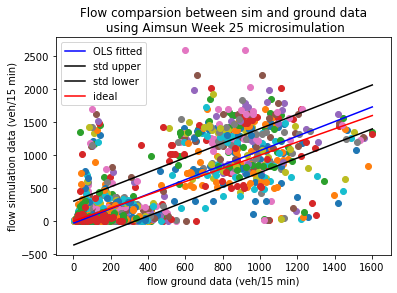

In [23]:
flow_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
flow_ground_file_name = "flow_processed_2019.csv"
flow_ground = pd.read_csv(os.path.join(flow_ground_folder, flow_ground_file_name))

analyzer.compare_flow(flow_ground)

R^2:  0.19949280064627495
slope 0.7846654472414516
intercept 6.605476287155124


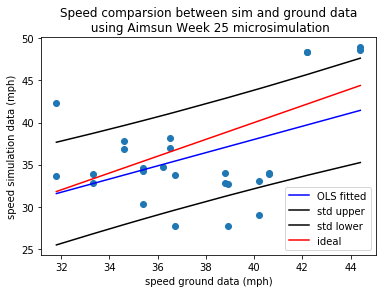

In [38]:
speed_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
speed_ground_file_name = "2015_Speed_Processed_Percent.csv"
speed_raw_folder = os.path.join(data_folder, "Data processing", "Raw", "Demand", "Flow_speed", "Kimley Horn Data")
speed_ground = pd.read_csv(os.path.join(speed_ground_folder, speed_ground_file_name)).fillna(0)[:-2] # currently missing road eid for last two rows in the ground truth speed file

analyzer.compare_speed(speed_ground, speed_raw_folder)

R^2:  0.0030407829966452304
slope 0.4358759565800631
intercept 540.4712473499687


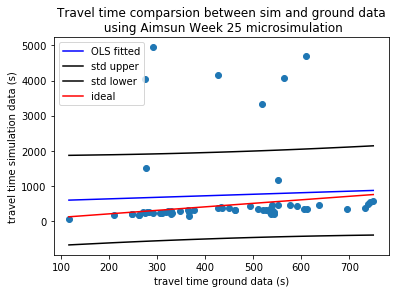

In [49]:
travel_time_ground_folder = os.path.join(data_folder,"Data processing","Auxiliary files","Demand","OD demand", "TravelTime")
travel_time_ground_file_name = "TravelTime.csv"
travel_time_ground = pd.read_csv(os.path.join(travel_time_ground_folder, travel_time_ground_file_name))

ID_correspondence_ground_folder = os.path.join(data_folder,"Data processing","Auxiliary files","Demand","OD demand")
ID_correspondence_file_name = "centroid ID.xlsx"
ID_corr = pd.read_excel(os.path.join(ID_correspondence_ground_folder, ID_correspondence_file_name), 'Sheet1').drop(columns=["Unnamed: 0"], axis=1)

analyzer.compare_travel_time(travel_time_ground, ID_corr, od_ids='All', time_intervals=[0,8,16,24])